<img src='../00_common/figures/iaeaheader.svg' style='width:100%'/>
<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
<em>E-learning course on <br / ><br / >
Advanced Neutron Imaging</em>
</p> 

# Filtering techniques
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

### What you will learn in this tutorial
The purpose of a filter is to modify images with the aim to enhance the relevant information. Until now, we have only worked and modified single pixels. With filters we expand our horizons to invole the pixel neighborhood. 

Traditional filters are based on convolution, more advanced filters use partial differential equations for achive the filtering effect. In this tutorial, we will mainly look at different methods to improve the signal to noise ratio (SNR) and remove outliers which are very common in neutron images. 

Low SNR is a often returning problem in neutron images due to the low counting statistics for given exposure times and neutron flux. This turorial will give you an introduction to different filtering techniques, mainly with the aim to suppress image noise.

- Filter characteristics
- Different filter kernels
- Filtering in 2D vs 3D
- What is the cost of using a filter
- Some advanced filters

### Needed mathematical concepts
- Convolution
- Noise and signal to noise ratio
- Histograms

#### Using the notebook
The cells in the notebook contain either executable python code or text. The cells are inteded to be executed in the order they appear and you can execute the code in a cell by pressing ctrl+enter or by clicking on the _Run_ button above. 

All code can be modified if you want to experiment with the code. Experimenting is even encouraged. It is always possible to get the original notebook from the repository if you would change the code too much.

The cells have been prepared in a manner that first demonstrates a concept and in some cases the needed plotting to show the result. The visualization is mostly not needed to understand at first, but it can give you some inspiration for your own future data visualization.


#### Before we start, we need to load some modules.
Python is a language that becomes powerful with the large number of modules that can be added. Each module has a specific purpose. The most important modules in this tutorial are ```numpy``` for mathmatical functions and numeric arrays and ```matplotlib``` for plotting data and showing images. A new module package in this tutorial is SciKit Image or ```skimage``` that provides image processing functions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tifffile as tiff
import skimage.filters as flt
import skimage.morphology as morph
from scipy.ndimage import convolve
import sys

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf ImageProcessing
    !git clone https://github.com/ImagingELearning/ImageProcessing.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/ImageProcessing/tutorials/00_common/data/"
    %pushd .
    %cd /content/ImageProcessing/tutorials/00_common/data
    !unzip beads.zip
    %popd
    sys.path.append("/content/scripts/python/")
    sys.path.append("/content/ImageProcessing/tutorials/00_common/")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"
    sys.path.append('../00_common/')

import readers as rd
    

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Real measurements are not perfect
You only get perfect images if draw them yourself. There is always noise present to some degree in a measurement. There are also different types of artifacts in neutron images like spots, lines and rings. 

In this tutorial, we will take a look at some filters that help making a confident analysis of the image data.

<img src="figures/imperfect_imaging_system.svg" style="width:800px"/>

## The data
In this tutorial, we will use a small 3D image from a neutron tomography of a packing of two sizes of copper breads in two layers. The scan time was a bit too short with a low SNR as consequence. We will initially use slices of the volume to later also look into 3D filtering.

In [5]:
img  = rd.read_images(data_path+'beads/beads_{0:04d}.tif',first=0, last=100)
vimg = img[:,img.shape[1]//2]
vimg = (vimg-vimg.min())/(vimg.max()-vimg.min())

  0%|          | 0/101 [00:00<?, ?it/s]

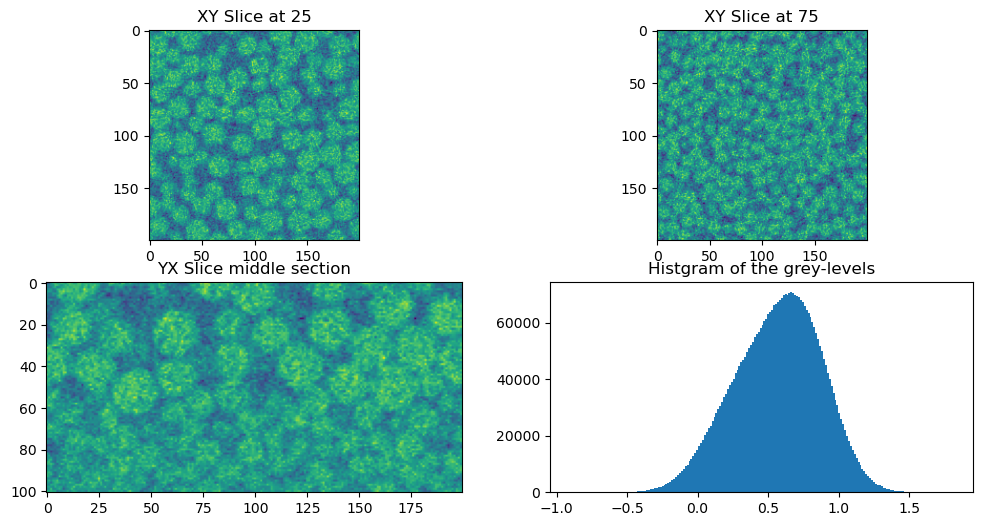

In [6]:
fig,ax = plt.subplots(2,2,figsize=(12,6))

ax=ax.ravel()
ax[0].imshow(img[25])
ax[0].set_title('XY Slice at 25')
ax[1].imshow(img[75])
ax[1].set_title('XY Slice at 75')
ax[2].imshow(vimg)
ax[2].set_title('YX Slice middle section');
ax[3].hist(img.ravel(),bins=200);
ax[3].set_title('Histgram of the grey-levels');

## Filter characteristics
Filters are characterized in terms of which information they enhance. Here, we talk about which frequencies pass through the filter and which are blocked.

The two main filter types are:
- __Low-pass__ filters - keep the slow fluctuations in the image. Mostly, these are the main information in the image. Sharp edges and noise will be reduced, the image is blurred.  
- __High-pass__ filters - keep rapid changes in the image. A high pass filtered image show the edges but low gradients are suppressed. A backside of the edge enhancement is that also noise which fluctuate from pixel to pixel seems to be amplified.
- __Band-pass__ filters - have a lower and upper cut-off frequency that limits the frequencies passing through the filter to an interval.

The figure below shows an image with two frequencies; the low frequencies are slow variations and the high frequencies are the rapid variations.

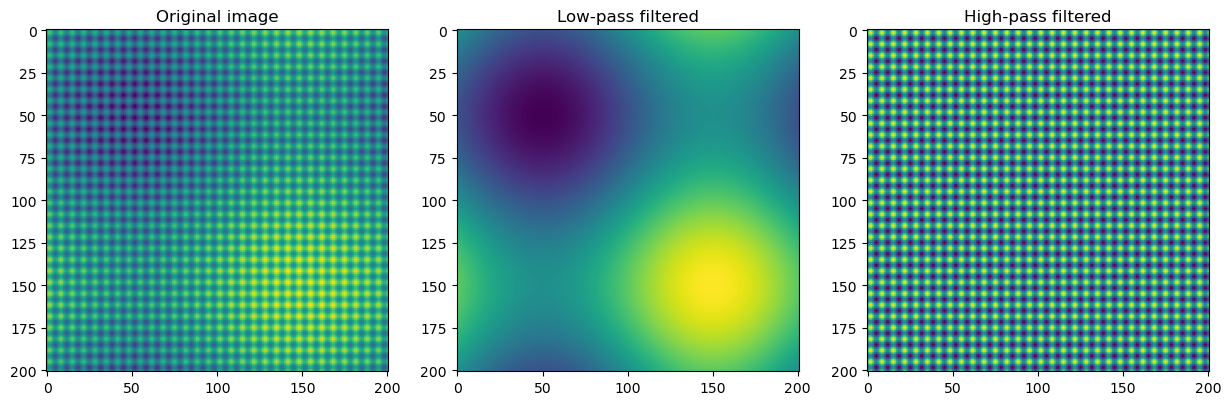

In [7]:
x,y = np.meshgrid(np.linspace(-np.pi,np.pi,201),np.linspace(-np.pi,np.pi,201))

lp = np.sin(x)+np.sin(y)
hp = np.sin(30*x)+np.sin(30*y)

fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(lp+hp)
ax[0].set_title('Original image');
ax[1].imshow(lp);
ax[1].set_title('Low-pass filtered');
ax[2].imshow(hp);
ax[2].set_title('High-pass filtered');

## Convolution basics and filter kernels
Convolution is a fundamental operation in filter theory. It is essentially computing a weighted sum of the pixels in a neighborhood around a pixel. 

$$(f*h)(x)=\sum_{i \in N_f} h(i) \cdot f(x+i), \forall x$$

where $f$ is the filtered image and $h$ is the so called filter kernel or weight matrix. The weighted sum is repeated for all pixels $x$ in the image.

In the 2D case with a symmetric $N\times N$ kernel, this equation can be rewritten as 

$$(f*h)(x,y)=\sum_{i=-N}^N \sum_{j=-N}^N h(i,j) \cdot f(x+i,y+j), \forall x,y$$

<img src="figures/principle_mean_filter.svg" style="width:500px"/>

The filter module on scikit image provides a collection of filters for different purposes.

https://scikit-image.org/docs/stable/api/skimage.filters.html

Before we start we need a visualization function to show the filter results

In [8]:
def show_result(A,B,name=None,k=1.96) :
    if name is None :
        name='Filtered'
        
    fig,ax = plt.subplots(2,2,figsize=(15,10))
    ax=ax.ravel()

    ax[0].imshow(A)
    ax[0].set_title("Original")
    ax[1].imshow(B)
    ax[1].set_title(name)
    d=A-B
    m=d.mean()
    s=d.std()
    ax[2].imshow(A-B,vmin=m-k*s,vmax=m+k*s)
    ax[2].set_title('Original - {0}'.format(name))
    bins=np.linspace(A.min(),A.max(),100)
    ax[3].hist(A.ravel(),bins=bins,alpha=0.5,label='Original')
    ax[3].hist(B.ravel(),bins=bins,alpha=0.5,label=name);
    ax[3].legend()

### The Gauss filter

The Gauss filter has a filter kernel based on the 2D Gaussian distribution 

$$G_{\sigma}(x,y)=e^{-\frac{x^2+y^2}{2*\sigma^2}}$$

The filter is one of the first goto types when you want to reduce the image noise

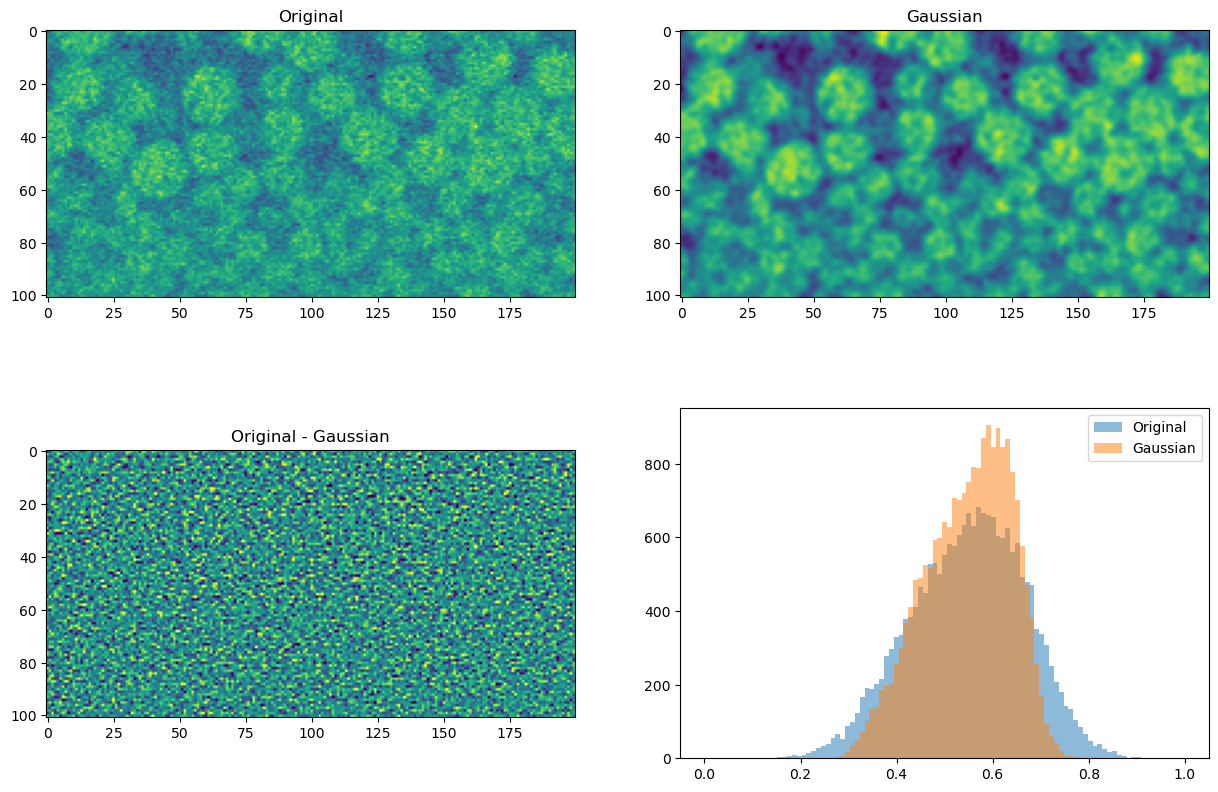

In [9]:
sigma = 1
g=flt.gaussian(vimg,sigma=sigma)
show_result(vimg,g,'Gaussian')

### The median filter

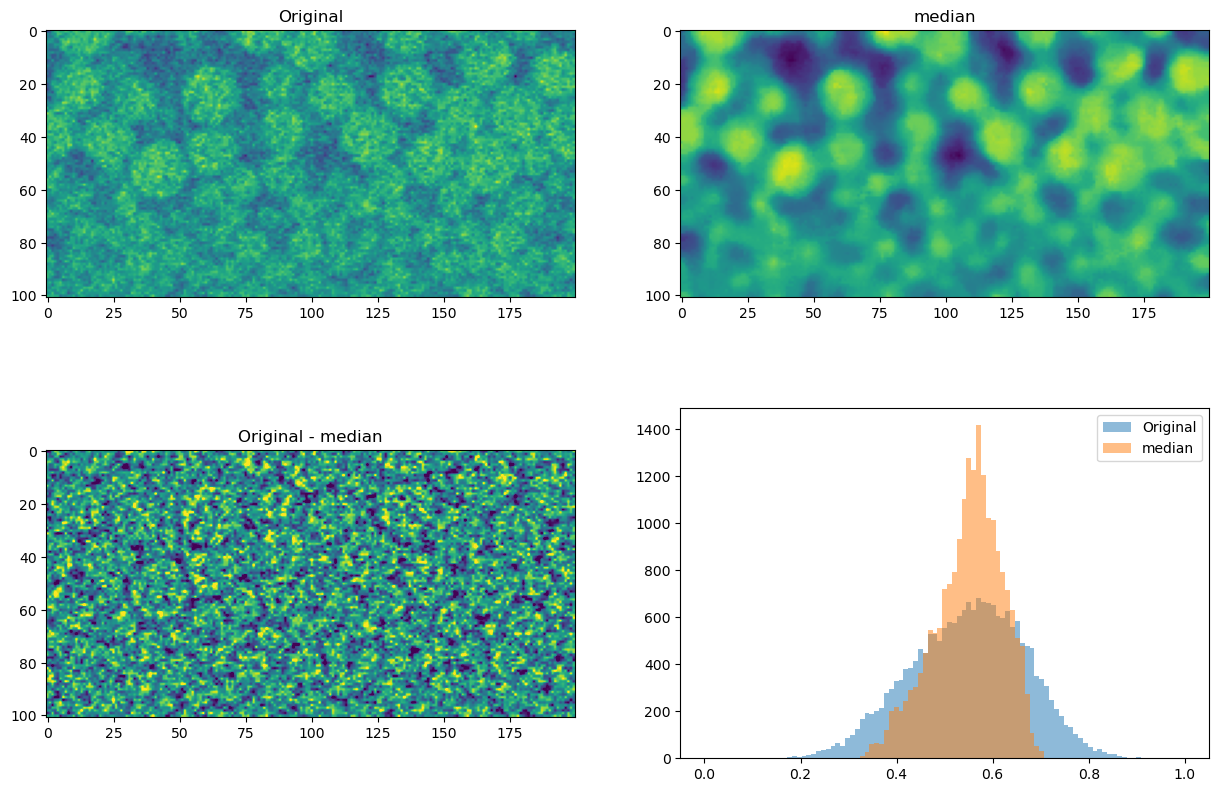

In [10]:
size=5
med=flt.median(vimg,morph.disk(size))
show_result(vimg,med, "median")

### Kernels with N odd vs. N even
It is generally recommended to use filter kernels with an odd number of elements. Let's see why this is recommended on a simplfied example. 

We create an image $f$ with a square in the middle and apply two uniform filter kernels, all filter weights are the same.

$h_3=U_{3\times 3}$ and $h_4=U_{4\times 4}$ 

compute 
$$f_3 = f * h_3$$

and 

$$f_4 = f * h_4$$

In [11]:
timg = np.zeros([25,25])
timg[5:20,5:20]=1.0

h3=np.ones([3,3])/9.0
v3=convolve(timg,h3)

h4=np.ones([4,4])/16
v4=convolve(timg,h4)

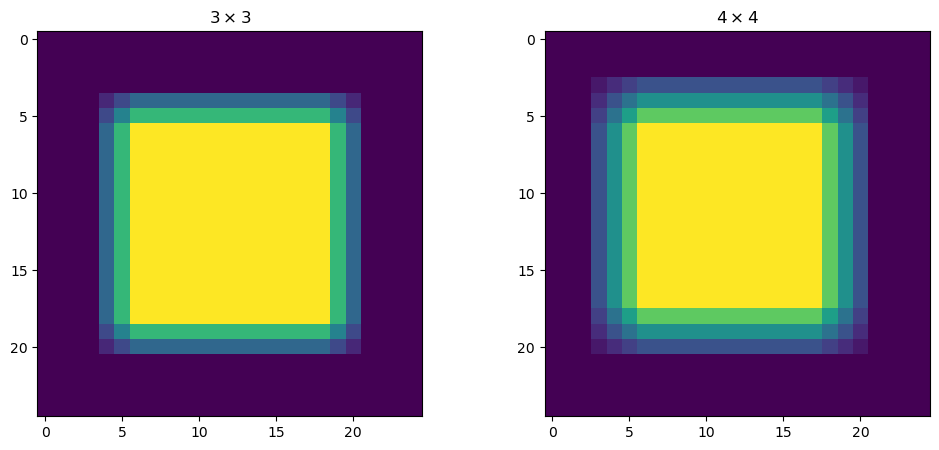

In [13]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax=ax.ravel()
ax[0].imshow(v3)
ax[0].set_title(r'$3\times 3$');
ax[1].imshow(v4);
ax[1].set_title(r'$4\times 4$');

At first glance, this looks fully ok. Now if we show the difference between original and filtered for the two cases.

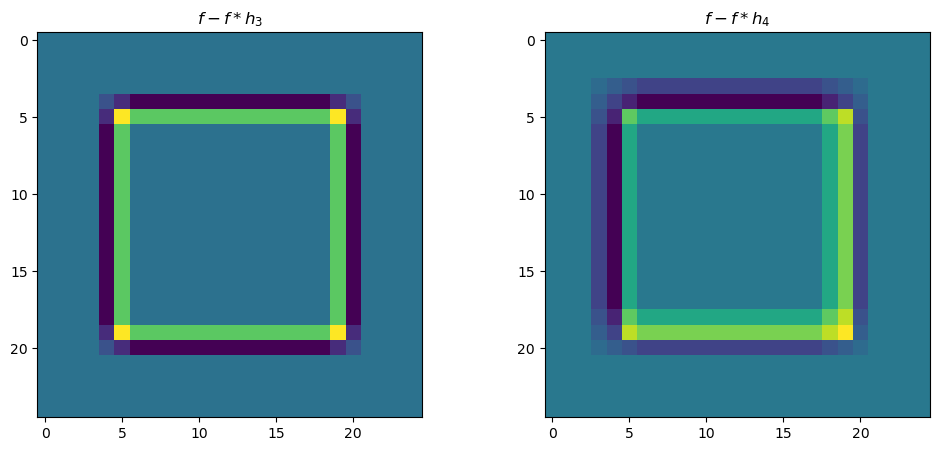

In [14]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax=ax.ravel()
ax[0].imshow(timg-v3)
ax[0].set_title(r'$f-f*h_3$')
ax[1].imshow(timg-v4)
ax[1].set_title(r'$f-f*h_4$');

The reason for this difference is that the kernel is applied asymmetrically on the neighborhood in the $N$ even case. This leads to a shift of the image which is undesireable due to possible misleading geometric interpretations. 

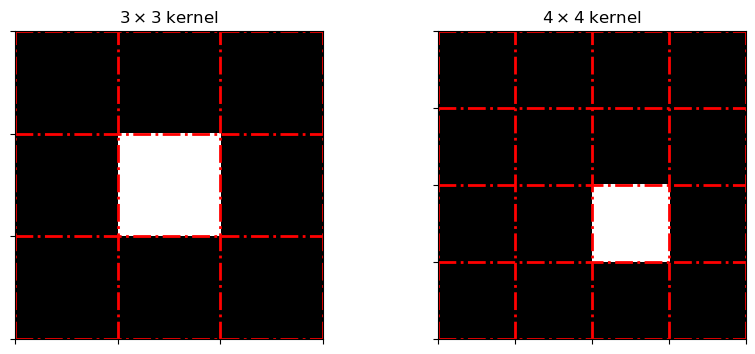

In [15]:
a=np.zeros([3,3])
a[1,1]=1
b=np.zeros([4,4])
b[2,2]=1

fig,ax= plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(a,cmap='gray')
ax[0].set_xticks(np.arange(-.5, 3, 1))
ax[0].set_yticks(np.arange(-.5, 3, 1))
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].grid(color='red', linestyle='-.', linewidth=2)
ax[0].set_title(r'$3 \times 3$ kernel')

ax[1].imshow(b,cmap='gray')
ax[1].set_xticks(np.arange(-.5, 4, 1))
ax[1].set_yticks(np.arange(-.5, 4, 1))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].grid(color='red', linestyle='-.', linewidth=2)
ax[1].set_title(r'$4 \times 4$ kernel');

## Application of filters - basic spot cleaning
One of the first artefacs you notice in neutron images are the spots. These are small outliers in the data with high intensity compared to the neighbor pixels. They are caused by gamma photon hitting the detector and thus leave a very intense response on the image. 

The figure below shows an example of some spot. They are as you can see not always perfect dots, but it could even be line traces.

<img src='figures/spotty_knot_closeup.png' style='width:400px'/>

The spots may look harmless in the radiograph. You can just rescale the display intervals. The do however have great impact on the reconstructed slices in tomography.

### Let's see what we can do
First we need an image with spots. In this case we use a projection from the tomography data set used to reconstruct the beads in the volume image above.

In [16]:
spots = rd.read_image(data_path+'spotimage.tif')

Here, you see the projection with the display dynamics matching min and max values in the image (left). This visualization leaves the relevant information in the dark due to the high intensity outliers. To the right, we adjusted the display dynamics to better match the inteval of the sample. Now, you can see both randomly distributed spots and the sample well.

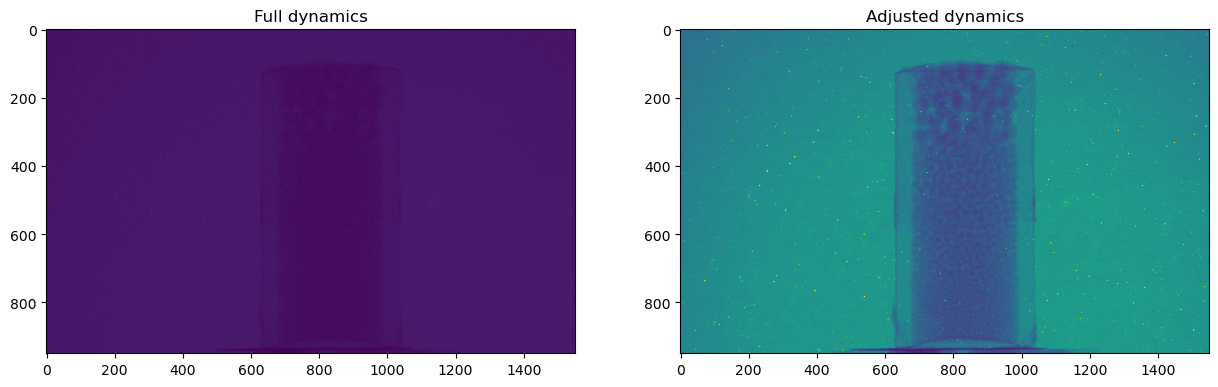

In [18]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].imshow(spots)
ax[0].set_title('Full dynamics')
ax[1].imshow(spots,vmin=300,vmax=3000)
ax[1].set_title('Adjusted dynamics');

The fact that the spots are misleading for the display is not severe, it can be easily dealt with. It does, however, become a problem when you start analysing the image and they add to a biased interpretation or also in tomography where each spot is the origin of a line of seemingly arbitrary orientation. Many lines together even appear as 
noise. 

The consequence is that if you want to use the images for more thatn only inspection, you need to remove them from the image as gently as possible.

### Methods to remove the spots
Spots are very localized rapid changes in the image data. This leads us in the direction of using a low-pass filter.
The options would be to use 
- Convolution filters with a Gauss or box kernel
- A median filter

These methods are however not ideal as they smooth the whole image regardless of outliers or not. 

#### Let's try a median filter
The median filter is good at suppressing outliers

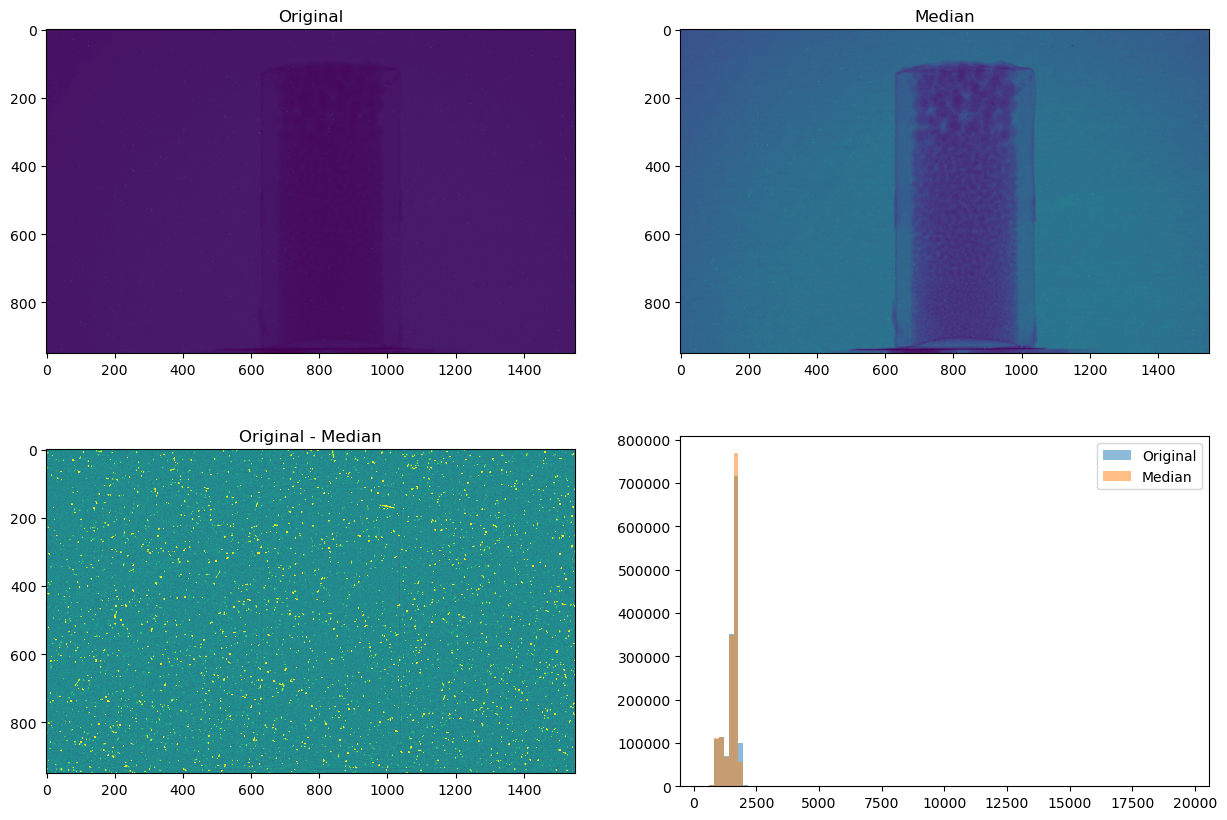

In [19]:
size=3
clean = flt.median(spots,np.ones((size,size))) 

show_result(spots,clean,'Median',k=1)

This cleaning looks good on first sight, but what if we tune the display interval a bit? 

Change the _k_ parameter in ```show_result``` in the cell above to 0.1. What do you see?

### A spot removal algorithm
A better choice is to work with a detect and replace concept that only targets the outlier spots. 

<img src='figures/spotclean_algorithm.svg' style='width:600px'/>

The described algorithm uses the difference between the original image and its median filtered version. The resulting difference image mainly show the outliers and some edges. By applying a threshold we can target the spots only. The last step of the algorithm is the replacement step where the detected spots are replaced by the median value corresponding to the location where the spot was detected.

The function below is a suggested implementation of the algorithm. There is also a suggested alternative option for the replacement.

In [20]:
def spot_clean(img,threshold,footprint) :
    mimg = flt.median(img,footprint)
    dimg = np.abs(img-mimg)
    
    mask = threshold<dimg 

    # option 1
    cleaned = mask * mimg + (1-mask) * img
    
    # option 2
#     cleaned       = img.copy()
#     cleaned[mask] = mimg[mask]
    
    return cleaned


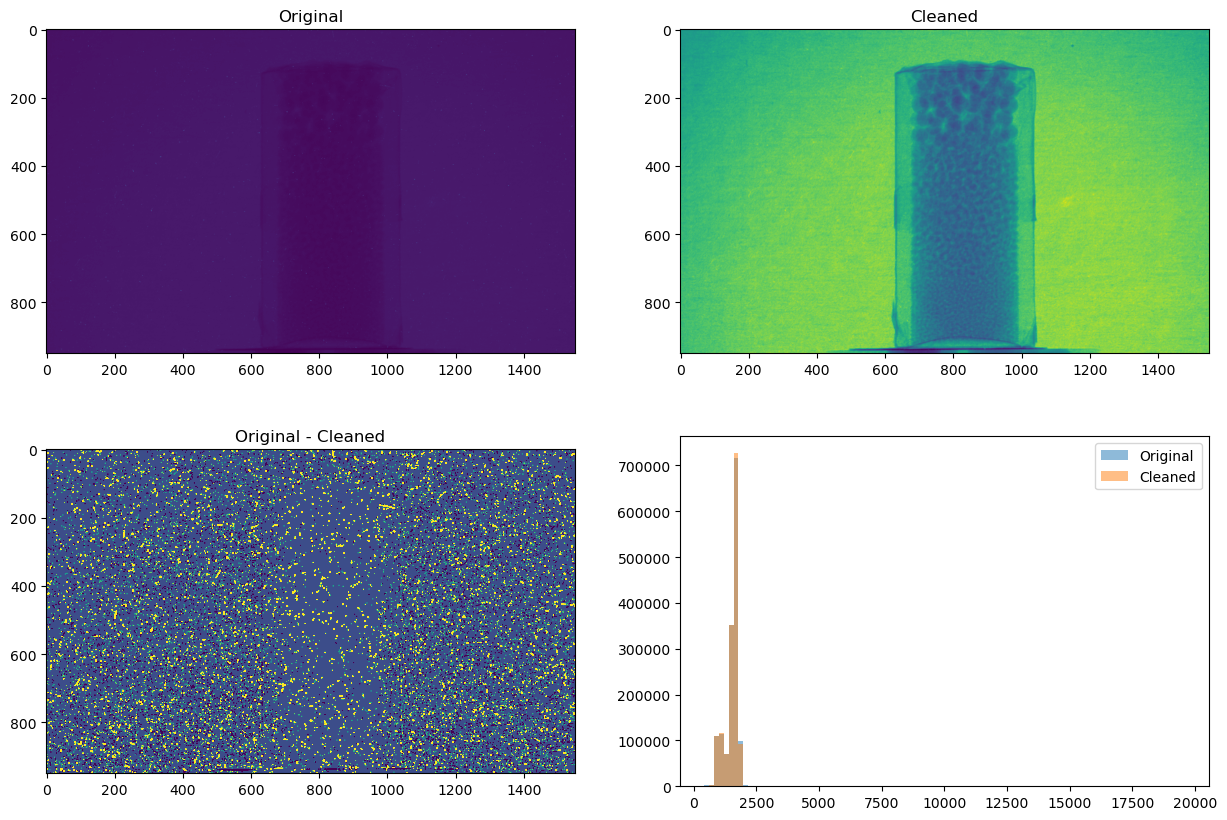

In [21]:
cleaned = spot_clean(spots,100,footprint=np.ones((5,5)))

show_result(spots,cleaned,'Cleaned',k=0.1)

How does it perform? Again try changing the _k_ to the same value you used for the median filter.

- Is it good? 
- Can you improve the performance? How?

## Filtering in 2D vs 3D

When you have 3D images it is important to use 3D filter kernels instead of filtering each slice using a 2D filter. 

The figure below shows an example of a $5\times 5$ and a $3\times 3\times 3$ filter kernel. This means they have 25 respectively 27 filter weights, so about the same. The difference is that the 3D filter is symmetric and more compact. This has the effect that the 2D filter will only filter in one plane while the 3D filters in all directions.
<img src="figures/neighborhoods.svg" style="width:400px"/>

In [22]:
# Convolution using uniform kernels in 2D and 3D
N=5
f2d = convolve(img,np.ones([1,N,N])/N**2)
N=3
f3d = convolve(img,np.ones([N,N,N])/N**3)

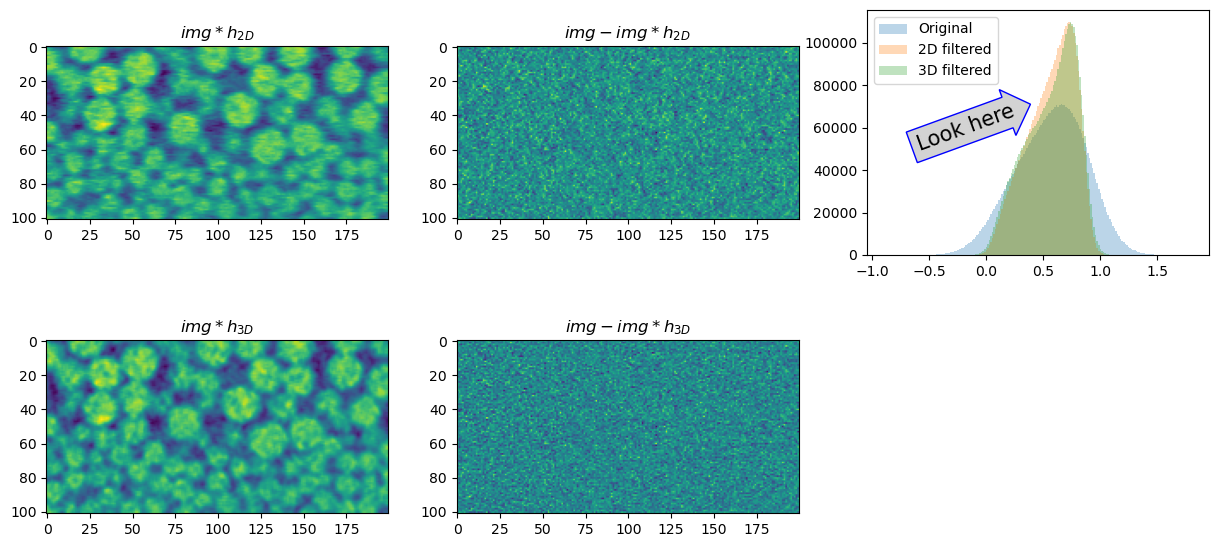

In [23]:
fig,ax = plt.subplots(2,3,figsize=(15,7))
ax=ax.ravel()
ax[0].imshow(f2d[:,:,f2d.shape[1]//2])
ax[0].set_title(r'$img * h_{2D}$')
ax[3].imshow(f3d[:,:,f3d.shape[1]//2])
ax[3].set_title(r'$img * h_{3D}$')
ax[1].imshow(img[:,:,img.shape[1]//2]-f2d[:,:,f2d.shape[1]//2])
ax[1].set_title(r'$img-img * h_{2D}$')
ax[4].imshow(img[:,:,img.shape[1]//2]-f3d[:,:,f3d.shape[1]//2])
ax[4].set_title(r'$img-img * h_{3D}$')
bins=np.linspace(img.min(),img.max(),200);
ax[2].hist(img.ravel(),bins=bins,alpha=0.3,label='Original')
ax[2].hist(f2d.ravel(),bins=bins,alpha=0.3,label='2D filtered')
ax[2].hist(f3d.ravel(),bins=bins,alpha=0.3,label='3D filtered')
ax[2].legend()
ax[2].text(
    0.27, 60000, "Look here", ha="right", va="center", rotation=20, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="lightgray", ec="b", lw=1))
ax[5].axis('off');


If you look closely in the two examples you may see that the 2D filtered image has smooth horizontal steaks. This is the effect of the anisotropic filter kernel shape. The histogram also confirms that the 3D filter is more efficient than slicewise 2D filtering. The 3D filter indicates a better class separation. 

__Note__: Working in ImageJ and using filter stack mostly applies 2D filters slice-wise.

## The cost of filtering
The purpose of applying a low pass filter is to improve the signal to noise ratio. The problem is that the filter besides suppressing noise also remove high frequency components from the image structures. These are for example edges of the items. In the following example we start with two disks with a small gap separating them and then apply filters of different strength to suppress the added noise.

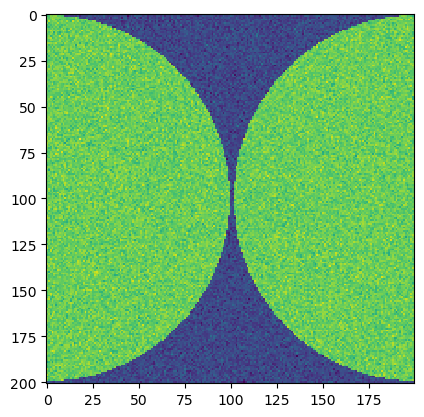

In [24]:
# Build the test image
x,y = np.meshgrid(np.linspace(-1,1,201),np.linspace(-1,1,201))
x = np.concatenate((x,x),axis=1)
y = np.concatenate((y,y),axis=1)
Gsigma=0.1
R = (np.sqrt(x**2+y**2)<0.995)+np.random.normal(0,Gsigma,size=x.shape)
R = R[:,100:300]
plt.imshow(R,interpolation='none');

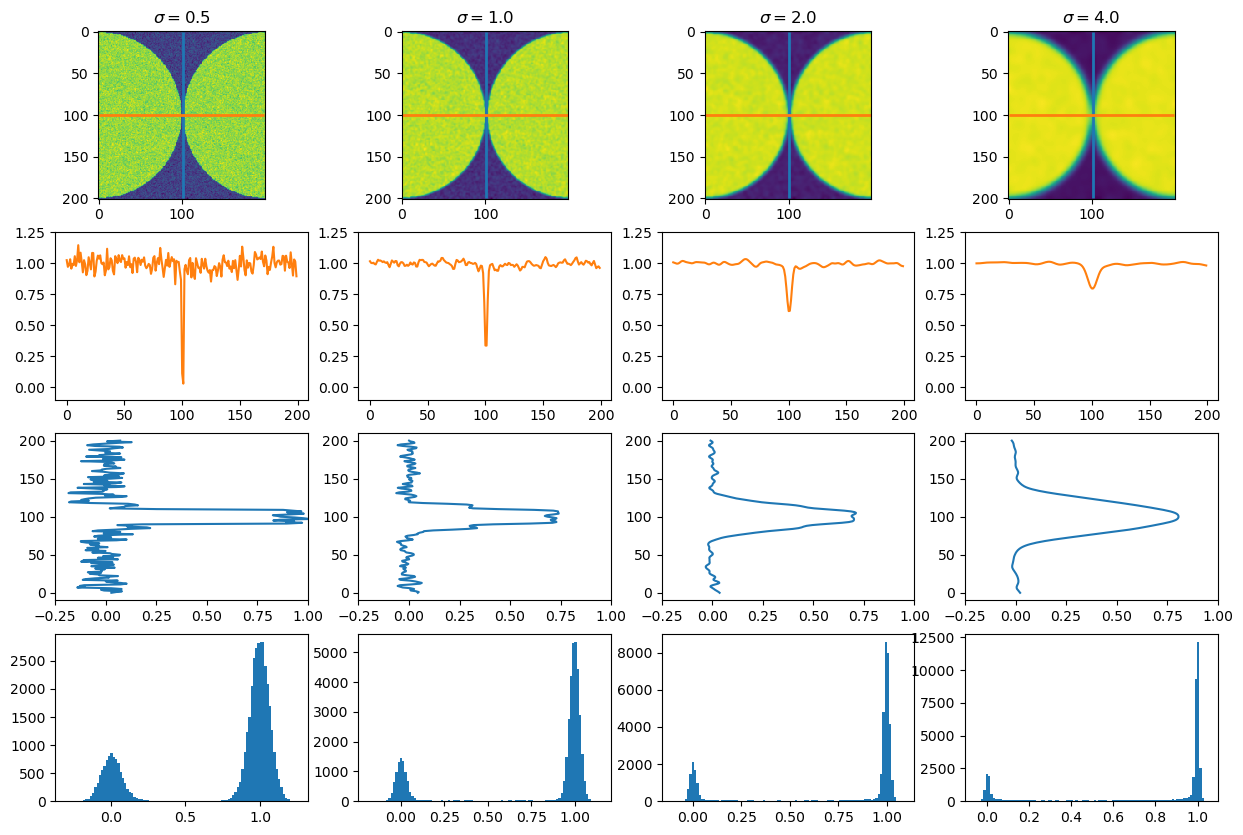

In [25]:
fig,ax=plt.subplots(4,4,figsize=(15,10))

# We will use Gaussians with the following widths
sigmas = [0.5,1,2,4]

for idx,sigma in enumerate(sigmas) :
    # Apply the filter 
    g=flt.gaussian(R,sigma=sigma) 
    
    # Plotting and visualization
    ax[0,idx].imshow(g,interpolation='none')
    ax[0,idx].set_title(r'$\sigma=${0:0.1f}'.format(sigma))
    ax[0,idx].vlines([101],ymin=0,ymax=g.shape[0]-1,color=colors[0],lw=2)
    ax[0,idx].hlines([100],xmin=0,xmax=g.shape[1]-1,color=colors[1],lw=2)
    ax[1,idx].plot(np.arange(g.shape[1]),g[100],color=colors[1])
    ax[1,idx].set_ylim([-0.1,1.25])
    ax[2,idx].plot(g[:,99],np.arange(g.shape[0]),color=colors[0])
    ax[2,idx].set_xlim([-0.25,1])
    ax[3,idx].hist(g.ravel(),bins=100)

This experiment shows that larger filter kernels successfully suppress the noise. The cost is also quite obvious; the edges are smoother. The profiles below the images show the image intensity in two directions across the gap between the two disks. The conclusion is that using larger filter kernels will reduce the contrast of the gap radically and make it harder to separate the two items. What happens when the SNR is even less? Change ```Gsigma```.

Repeat the experiment with a median filter

In [26]:
# your code

What is your conclusion?

## Some advanced filters
In the previous section, we saw that noise reduction using convolution filters may destroy relevant features or make them wider. Avoiding this is an active field in image processing research and several methods have been proposed over the years. The restoration module in scikit image provides a selection of denoising filters. 

https://scikit-image.org/docs/stable/api/skimage.restoration.html

In this section you will get a glimpse of what these filters can achieve, but it is beyond the scope of this tutorial to explain the details that often requires solving partial differential equations to restore the image from the noise component.

__Note__: These filters work best if the data is normalized using
$$f=\frac{f_0-f_{min}}{f_{max}-f_{min}}$$

In [27]:
import skimage.restoration as restore

### Bilateral filtering
Citing [wikipedia](https://en.wikipedia.org/wiki/Bilateral_filter):
>A bilateral filter is a non-linear, edge-preserving, and noise-reducing smoothing filter for images. It replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels. This weight can be based on a Gaussian distribution. Crucially, the weights depend not only on Euclidean distance of pixels, but also on the radiometric differences (e.g., range differences, such as color intensity, depth distance, etc.). This preserves sharp edges.

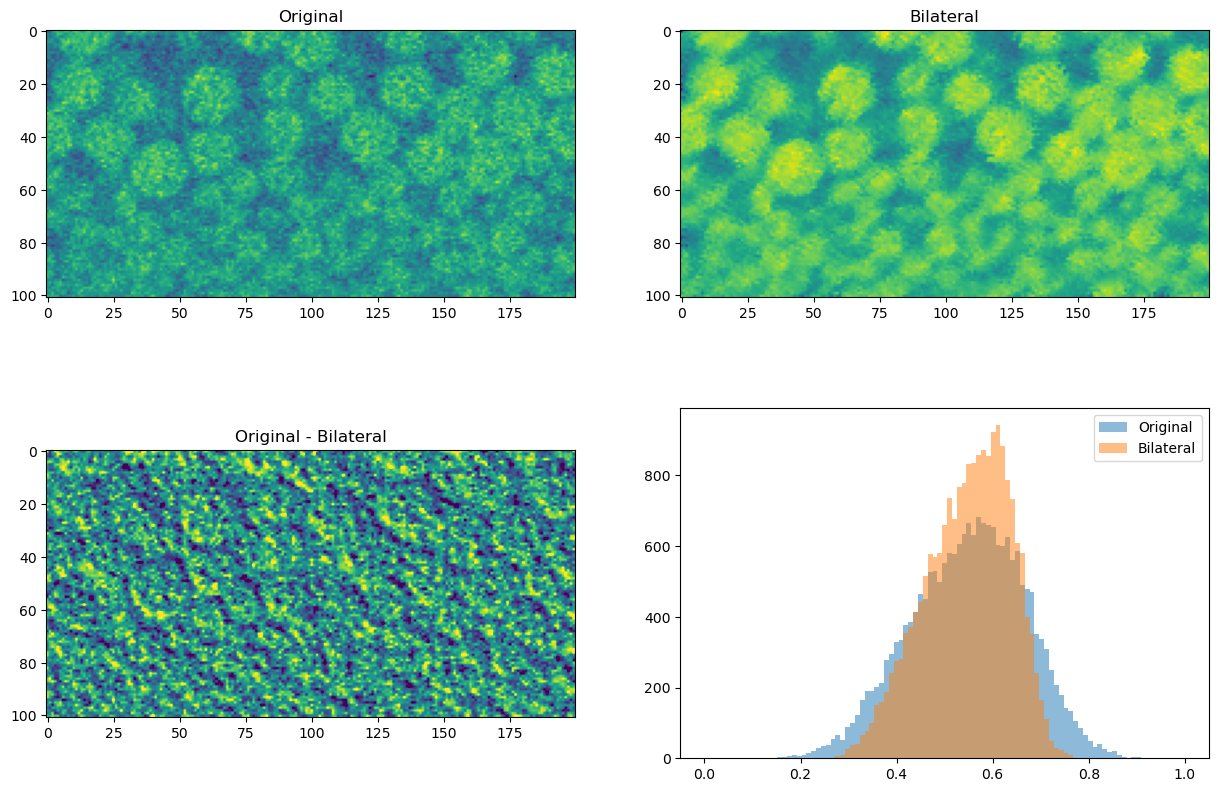

In [28]:
blf=restore.denoise_bilateral(vimg,
                          win_size=None, 
                          sigma_color=None, 
                          sigma_spatial=1, # This is the important parameter for filter tuning
                          bins=1000, 
                          mode='constant', 
                          cval=0);

show_result(vimg,blf,"Bilateral")

__NOTE__: The implementation in skimage is unfortunately not good as it shifts the image.

### Non-local means filtering

Non-local means achieve a noise suppressing effect by averaging all pixels with similar neigborhood. A notebook explaining some more details can be found among the [Quantitative Big Imaging lectures]() from ETH Zürich.

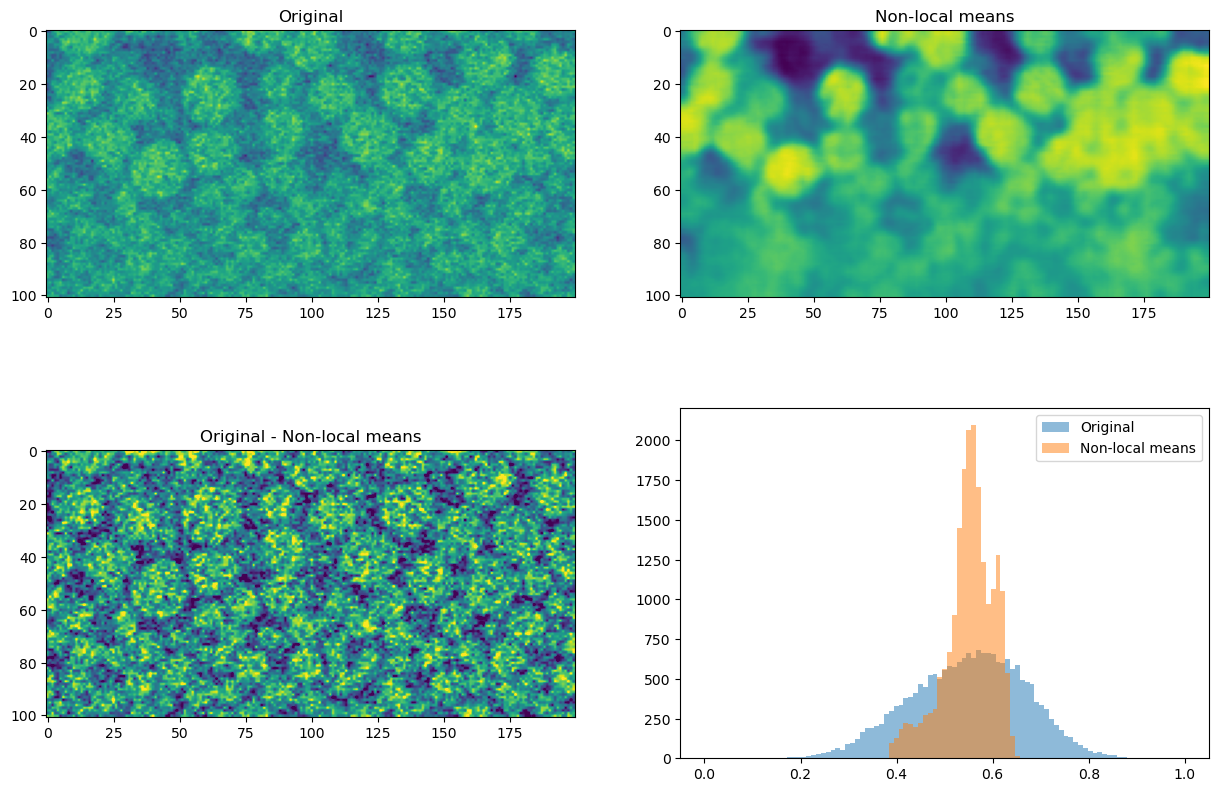

In [29]:
nl = restore.denoise_nl_means(vimg, 
                              patch_size=7, 
                              patch_distance=11, 
                              h=0.15,              # This is the important parameter for filter tuning
                              fast_mode=True, 
                              sigma=0.05, 
                              preserve_range=False)

show_result(vimg,nl,"Non-local means")

### Total variation filter

TV filters minimize the total variation of the image ($f$) 
$$TV_1(f) = \int_{\Omega}\|\nabla f\|$$
or 
$$TV_2(f) = \int_{\Omega}\|\nabla f\|^2$$

The TV of a noisy image is greater than for an image with less or no noise.

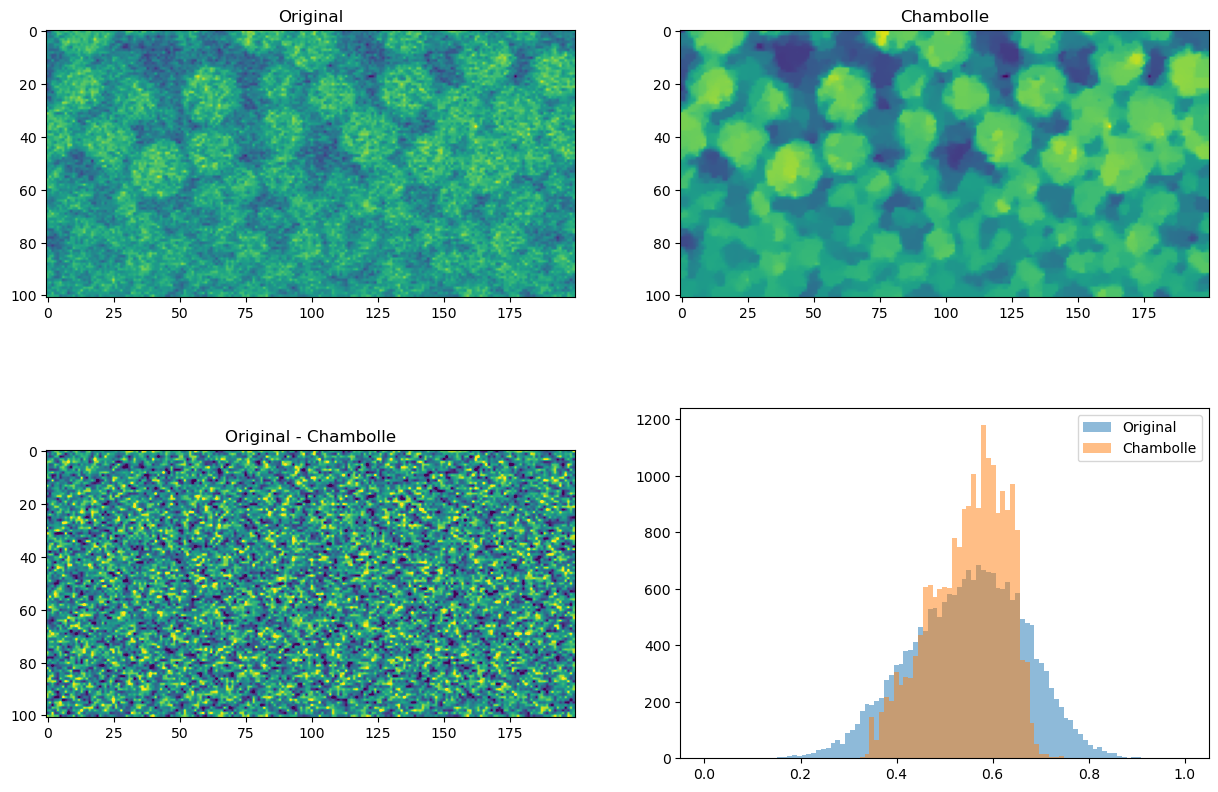

In [30]:
cham= restore.denoise_tv_chambolle(vimg, 
                           weight=0.08, 
                           eps=0.00001)

show_result(vimg,cham,'Chambolle')

Total variation filters is a class of filters that have great ability to supress image noise. They may however be quite hard to tune. The result appears patchy depending on the type of regulariztion criterion. 

## Summary

In this tutorial we got a brief insight in the use of image filters
- The basic filter operation is based on convolution, which in practice means that weighted averages from the neighborhood produce the filter output.
- Low pass filters can be used to suppress image noise.
- Filters can be used to remove gamma spots form neutron images.
- You should use 3D filters on volume images.
- Filtering does alter more of the image than removing the noise.